In [1]:
from zoish.feature_selectors.optunashap import OptunaShapFeatureSelector
import xgboost
from optuna.pruners import HyperbandPruner
from optuna.samplers._tpe.sampler import TPESampler
from sklearn.model_selection import KFold,train_test_split
import pandas as pd
from sklearn.pipeline import Pipeline
from feature_engine.imputation import (
    CategoricalImputer,
    MeanMedianImputer
    )
from category_encoders import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score)
import matplotlib.pyplot as plt
import optuna


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
[I 2022-09-07 06:20:46,595] A new study created in memory with name: no-name-cab76b90-f011-4ee0-b331-f8a258223d73


<Figure size 432x288 with 0 Axes>

# Example 1 : Use Adult Data Set (a classification problem)
  
https://archive.ics.uci.edu/ml/datasets/Adult

In [2]:
urldata= "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
# column names
col_names=["age", "workclass", "fnlwgt" , "education" ,"education-num",
"marital-status","occupation","relationship","race","sex","capital-gain","capital-loss","hours-per-week",
"native-country","label"
]
# read data
data = pd.read_csv(urldata,header=None,names=col_names,sep=',')
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# Define labels


In [3]:
data.loc[data['label']=='<=50K','label']=0
data.loc[data['label']==' <=50K','label']=0

data.loc[data['label']=='>50K','label']=1
data.loc[data['label']==' >50K','label']=1

data['label']=data['label'].astype(int)

# Train test split

In [4]:
X = data.loc[:, data.columns != "label"]
y = data.loc[:, data.columns == "label"]


X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.33, stratify=y['label'], random_state=42)


# Find feature types for later use

In [5]:
int_cols =  X_train.select_dtypes(include=['int']).columns.tolist()
float_cols =  X_train.select_dtypes(include=['float']).columns.tolist()
cat_cols =  X_train.select_dtypes(include=['object']).columns.tolist()


# Define Feature selector and set it argumens 

In [6]:
optuna_classification_lgb = OptunaShapFeatureSelector(
        # general argument setting        
        verbose=1,
        random_state=0,
        logging_basicConfig = None,
        # general argument setting        
        n_features=4,
        list_of_obligatory_features_that_must_be_in_model=[],
        list_of_features_to_drop_before_any_selection=[],
        # shap argument setting  
        estimator=xgboost.XGBClassifier(),
        estimator_params={
        "max_depth": [4, 9],
        "reg_alpha": [0, 1],
        "objective":['binary:logistic'],

        },
      
        # shap arguments
        model_output="raw", 
        feature_perturbation="interventional", 
        algorithm="auto", 
        shap_n_jobs=-1, 
        memory_tolerance=-1, 
        feature_names=None, 
        approximate=False, 
        shortcut=False, 
        plot_shap_summary=False,
        save_shap_summary_plot=True,
        path_to_save_plot = './summary_plot.png',
        shap_fig = plt.figure(),
        ## optuna params
        test_size=0.33,
        with_stratified = False,
        performance_metric = 'f1',
        # optuna study init params
        study = optuna.create_study(
            storage = None,
            sampler = TPESampler(),
            pruner= HyperbandPruner(),
            study_name  = None,
            direction = "maximize",
            load_if_exists = False,
            directions  = None,
            ),
        study_optimize_objective_n_trials=10, 

)

[I 2022-09-07 06:20:47,575] A new study created in memory with name: no-name-cacb4c0a-a036-40f1-b6c2-4ae3c428ba0f
root - INFO - Setting value for logging_basicConfig
root - INFO - Setting value for verbose
root - INFO - Setting value for xgbse_focus
root - INFO - Setting value for random_state
root - INFO - Setting value for n_features
root - INFO - Setting value for list_of_obligatory_features_that_must_be_in_model
root - INFO - Setting value for list of features to drop before any selection
root - INFO - Setting value for estimator
root - INFO - Getting value for estimator
root - INFO - XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
  

<Figure size 432x288 with 0 Axes>

# Build sklearn Pipeline

In [7]:


pipeline =Pipeline([
            # int missing values imputers
            ('intimputer', MeanMedianImputer(
                imputation_method='median', variables=int_cols)),
            # category missing values imputers
            ('catimputer', CategoricalImputer(variables=cat_cols)),
            #
            ('catencoder', OrdinalEncoder()),
            # feature selection
            ('optuna_classification_lgb', optuna_classification_lgb),
            # classification model
            ('logistic', LogisticRegression())


 ])



# Run Pipeline

root - INFO - Getting value for estimator
root - INFO - Getting value for performance metric
root - INFO - Getting value for estimator_params
root - INFO - Getting value for verbose
root - INFO - Getting value for test_size
root - INFO - Getting value for random_state
root - INFO - Getting value for study
root - INFO - Getting value for study optimize objective
root - INFO - Getting value for study_optimize_objective_n_trials
root - INFO - Getting value for study_optimize_objective_timeout
root - INFO - Getting value for study_optimize_n_jobs
root - INFO - Getting value for study_optimize_catch
root - INFO - Getting value for study_optimize_callbacks
root - INFO - Getting value for study_optimize_gc_after_trial
root - INFO - Getting value for study_optimize_show_progress_bar
root - INFO - Getting value for with_stratified
root - INFO - Getting value for xgbse_focus


[0]	validation-logloss:0.55277
[0]	validation-logloss:0.54243
[0]	validation-logloss:0.54454
[0]	validation-logloss:0.55276
[0]	validation-logloss:0.54651
[0]	validation-logloss:0.55270
[0]	validation-logloss:0.54482
[1]	validation-logloss:0.47507
[0]	validation-logloss:0.54173
[1]	validation-logloss:0.47512
[1]	validation-logloss:0.47527
[1]	validation-logloss:0.46495
[2]	validation-logloss:0.42639
[1]	validation-logloss:0.46326
[2]	validation-logloss:0.42644[2]	validation-logloss:0.42688

[1]	validation-logloss:0.46146
[1]	validation-logloss:0.46305
[3]	validation-logloss:0.39407
[3]	validation-logloss:0.39457[3]	validation-logloss:0.39412

[1]	validation-logloss:0.46039
[2]	validation-logloss:0.41414
[4]	validation-logloss:0.37273
[2]	validation-logloss:0.41058
[4]	validation-logloss:0.37290[4]	validation-logloss:0.37278



`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.


[2]	validation-logloss:0.41144
[2]	validation-logloss:0.40970
[5]	validation-logloss:0.35687
[3]	validation-logloss:0.38108
[5]	validation-logloss:0.35691
[5]	validation-logloss:0.35707
[2]	validation-logloss:0.40892
[3]	validation-logloss:0.37690
[6]	validation-logloss:0.34684
[6]	validation-logloss:0.34689
[6]	validation-logloss:0.34691
[3]	validation-logloss:0.37836
[4]	validation-logloss:0.35858
[7]	validation-logloss:0.33820
[3]	validation-logloss:0.37715
[7]	validation-logloss:0.33824
[7]	validation-logloss:0.33824
[8]	validation-logloss:0.33156
[4]	validation-logloss:0.35491
[8]	validation-logloss:0.33162
[8]	validation-logloss:0.33159
[3]	validation-logloss:0.37654
[5]	validation-logloss:0.34207
[4]	validation-logloss:0.35546
[9]	validation-logloss:0.32686
[9]	validation-logloss:0.32651
[4]	validation-logloss:0.35432
[9]	validation-logloss:0.32689
[6]	validation-logloss:0.33224[5]	validation-logloss:0.33998



[I 2022-09-07 06:20:48,133] Trial 7 finished with value: 0.6429305032523109 and parameters: {'max_depth': 4, 'reg_alpha': 0.3075797116097816, 'objective': 'binary:logistic'}. Best is trial 7 with value: 0.6429305032523109.


[5]	validation-logloss:0.33975


[I 2022-09-07 06:20:48,137] Trial 0 finished with value: 0.6429312132734186 and parameters: {'max_depth': 4, 'reg_alpha': 0.01813148003284626, 'objective': 'binary:logistic'}. Best is trial 0 with value: 0.6429312132734186.


[4]	validation-logloss:0.35320


[I 2022-09-07 06:20:48,156] Trial 6 finished with value: 0.6424657534246576 and parameters: {'max_depth': 4, 'reg_alpha': 0.2883933533777495, 'objective': 'binary:logistic'}. Best is trial 0 with value: 0.6429312132734186.


[5]	validation-logloss:0.33855
[7]	validation-logloss:0.32531
[6]	validation-logloss:0.32887
[6]	validation-logloss:0.32973
[0]	validation-logloss:0.54932
[0]	validation-logloss:0.54933
[5]	validation-logloss:0.33677
[8]	validation-logloss:0.31961
[1]	validation-logloss:0.47001
[6]	validation-logloss:0.32799
[7]	validation-logloss:0.32017
[1]	validation-logloss:0.47039
[7]	validation-logloss:0.32184
[9]	validation-logloss:0.31631
[2]	validation-logloss:0.41991
[2]	validation-logloss:0.42044
[6]	validation-logloss:0.32649
[7]	validation-logloss:0.31971
[8]	validation-logloss:0.31543
[8]	validation-logloss:0.31513[3]	validation-logloss:0.38684



[I 2022-09-07 06:20:48,261] Trial 5 finished with value: 0.6666666666666666 and parameters: {'max_depth': 6, 'reg_alpha': 0.38916705554741104, 'objective': 'binary:logistic'}. Best is trial 5 with value: 0.6666666666666666.


[3]	validation-logloss:0.38741
[4]	validation-logloss:0.36457
[7]	validation-logloss:0.31954
[4]	validation-logloss:0.36504
[8]	validation-logloss:0.31540
[9]	validation-logloss:0.31176
[9]	validation-logloss:0.31092
[5]	validation-logloss:0.34979
[5]	validation-logloss:0.35024


[I 2022-09-07 06:20:48,321] Trial 4 finished with value: 0.6767810026385224 and parameters: {'max_depth': 7, 'reg_alpha': 0.06326849045141614, 'objective': 'binary:logistic'}. Best is trial 4 with value: 0.6767810026385224.
[I 2022-09-07 06:20:48,321] Trial 2 finished with value: 0.6802721088435374 and parameters: {'max_depth': 7, 'reg_alpha': 0.6974483030213288, 'objective': 'binary:logistic'}. Best is trial 2 with value: 0.6802721088435374.


[8]	validation-logloss:0.31415
[6]	validation-logloss:0.33858[9]	validation-logloss:0.31175

[6]	validation-logloss:0.33872
[7]	validation-logloss:0.33066
[7]	validation-logloss:0.33084
[9]	validation-logloss:0.30888


[I 2022-09-07 06:20:48,352] Trial 1 finished with value: 0.6803385416666666 and parameters: {'max_depth': 8, 'reg_alpha': 0.9163305332955618, 'objective': 'binary:logistic'}. Best is trial 1 with value: 0.6803385416666666.


[8]	validation-logloss:0.32511
[8]	validation-logloss:0.32614


[I 2022-09-07 06:20:48,368] Trial 3 finished with value: 0.6809616634178038 and parameters: {'max_depth': 8, 'reg_alpha': 0.036340502314841316, 'objective': 'binary:logistic'}. Best is trial 3 with value: 0.6809616634178038.


[9]	validation-logloss:0.32054
[9]	validation-logloss:0.32136


[I 2022-09-07 06:20:48,387] Trial 8 finished with value: 0.654950996958432 and parameters: {'max_depth': 5, 'reg_alpha': 0.27028572564495257, 'objective': 'binary:logistic'}. Best is trial 3 with value: 0.6809616634178038.
[I 2022-09-07 06:20:48,390] Trial 9 finished with value: 0.6515561569688769 and parameters: {'max_depth': 5, 'reg_alpha': 0.8941760810584997, 'objective': 'binary:logistic'}. Best is trial 3 with value: 0.6809616634178038.


{'max_depth': 8, 'reg_alpha': 0.036340502314841316, 'objective': 'binary:logistic'}
[0]	validation-logloss:0.54173
[1]	validation-logloss:0.46039
[2]	validation-logloss:0.40892
[3]	validation-logloss:0.37654
[4]	validation-logloss:0.35320
[5]	validation-logloss:0.33677
[6]	validation-logloss:0.32649
[7]	validation-logloss:0.31954
[8]	validation-logloss:0.31415
[9]	validation-logloss:0.30888


root - INFO - Setting value for best estimator
root - INFO - Getting value for estimator
root - INFO - Getting value for estimator
root - INFO - Getting value for best estimator
root - INFO - Getting value for model_output
root - INFO - Getting value for feature perturbation
root - INFO - Getting value for algorithm
root - INFO - Getting value for shap_n_jobs
root - INFO - Getting value for memory_tolerance
root - INFO - Getting value for feature_names
root - INFO - Getting value for approximate
root - INFO - Getting value for shortcut


XGBClassifier


root - INFO - Getting value for plot shap summary
root - INFO - Getting value for save_shap_summary_plot
root - INFO - Getting value for n_features


.values =
array([[-9.10303789e-01, -1.12843513e-02, -1.24129955e-02, ...,
        -4.80518372e-02, -8.65773615e-02,  6.02098209e-03],
       [-3.96913426e-01, -1.46956966e-02, -1.94955011e-02, ...,
        -2.39463445e-02, -8.21640032e-02,  2.63483514e-03],
       [ 1.75606696e-01, -2.64018862e-02, -5.40810376e-02, ...,
        -3.25700751e-02, -1.10812352e-01,  2.40987836e-03],
       ...,
       [ 3.24966017e-01, -1.73864848e-02,  2.49571584e-02, ...,
        -5.62963346e-02,  2.36158086e-01,  5.67035791e-03],
       [-7.50866507e-01, -3.52910553e-02, -9.26629802e-02, ...,
        -7.88950512e-02,  2.11419847e-01,  2.60363899e-02],
       [-6.61772492e-01, -9.97473222e-03,  4.71244369e-02, ...,
        -2.64343525e-02, -5.59895344e-02, -6.16705858e-04]])

.base_values =
array([[-1.32896655],
       [-1.32896655],
       [-1.32896655],
       ...,
       [-1.32896655],
       [-1.32896655],
       [-1.32896655]])

.data =
array([[    24,      1, 228649, ...,      0,     38,      1],
 

root - INFO - Getting value for path_to_save_plot
root - INFO - Getting value for shap_fig
Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
root - INFO - Setting value for importance_df
root - INFO - Getting value for importance_df
root - INFO - Getting value for importance_df
root - INFO - Getting value for importance_df
root - INFO - Getting value for importance_df
root - INFO - Setting value for importance_df
root - INFO - Getting value for importance_df
root - INFO - Getting value for importance_df
root - INFO - Getting value for n_features
root - INFO - Getting value for n_features
root - INFO - Getting value for importance_df
root - INFO - Getting value for importance_df
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


                 0         1
0              age  0.346439
1        workclass   0.03468
2           fnlwgt  0.032279
3        education   0.01282
4    education-num   0.36053
5   marital-status  0.952064
6       occupation  0.186888
7     relationship  0.139749
8             race  0.005657
9              sex  0.062113
10    capital-gain  0.321273
11    capital-loss  0.082421
12  hours-per-week  0.183555
13  native-country  0.011391
       column_name shap_importance
0              age        0.346439
1        workclass         0.03468
2           fnlwgt        0.032279
3        education         0.01282
4    education-num         0.36053
5   marital-status        0.952064
6       occupation        0.186888
7     relationship        0.139749
8             race        0.005657
9              sex        0.062113
10    capital-gain        0.321273
11    capital-loss        0.082421
12  hours-per-week        0.183555
13  native-country        0.011391
       column_name shap_importance
5   m

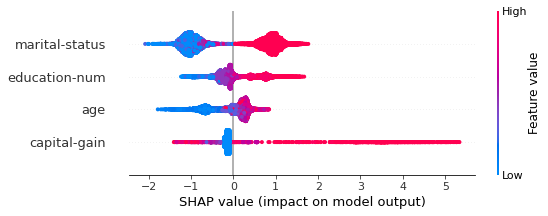

In [8]:
pipeline.fit(X_train,y_train)
y_pred = pipeline.predict(X_test)


# Check performance of the Pipeline

In [9]:
print('F1 score : ')
print(f1_score(y_test,y_pred))
print('Classification report : ')
print(classification_report(y_test,y_pred))
print('Confusion matrix : ')
print(confusion_matrix(y_test,y_pred))


F1 score : 
0.6111595466434175
Classification report : 
              precision    recall  f1-score   support

           0       0.86      0.93      0.89      8158
           1       0.70      0.54      0.61      2588

    accuracy                           0.83     10746
   macro avg       0.78      0.73      0.75     10746
weighted avg       0.83      0.83      0.83     10746

Confusion matrix : 
[[7560  598]
 [1186 1402]]
